# Testing the VAE on MNIST dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from dynalearn.datasets.mnist_dataset import load_MNIST, one_hot_to_int
from dynalearn.models.vae import VAE,FC_VAE

def display_number(imag, ax):
    ax.imshow(imag, cmap="gray")
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

In [2]:
mnist_train, mnist_test = load_MNIST("./data/mnist", vectorize=True, target_onehot=True, num_train=60000,
                                     num_val=1000)

vae = FC_VAE(28 * 28, [512, 256, 128], 2, keepprob=0.99,
             optimizer=lambda p: torch.optim.Adam(p, lr=1e-3, weight_decay=0))
print(vae)

VAE(
  (encoder): Fc_Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.010000000000000009)
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.010000000000000009)
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): Tanh()
      (8): Dropout(p=0.010000000000000009)
    )
    (mu): Linear(in_features=128, out_features=2, bias=True)
    (var): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Fc_Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.010000000000000009)
      (3): Linear(in_features=128, out_features=256, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.010000000000000009)
      (6): Linear(in_features=256, out_features=512, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.010000000000000009)
      (9):

## Training the vae

In [3]:
vae.fit(mnist_train, mnist_test, epochs=50, batch_size=128, verbose=True, keep_best=True)

/home/charles/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 0 - Train loss: 160.4736 - Val loss: 158.6731 - Training time: 31.4878 - New best config.
Epoch 1 - Train loss: 151.8015 - Val loss: 151.0110 - Training time: 37.8443 - New best config.
Epoch 2 - Train loss: 148.6279 - Val loss: 148.3099 - Training time: 36.5550 - New best config.
Epoch 3 - Train loss: 146.9776 - Val loss: 146.5946 - Training time: 37.3826 - New best config.
Epoch 4 - Train loss: 145.5556 - Val loss: 145.0776 - Training time: 38.8663 - New best config.
Epoch 5 - Train loss: 145.1104 - Val loss: 144.3725 - Training time: 39.3104 - New best config.
Epoch 6 - Train loss: 144.1987 - Val loss: 143.7539 - Training time: 39.4004 - New best config.
Epoch 7 - Train loss: 143.3292 - Val loss: 143.0610 - Training time: 38.8895 - New best config.
Epoch 8 - Train loss: 143.2197 - Val loss: 142.8178 - Training time: 39.2841 - New best config.
Epoch 9 - Train loss: 142.0202 - Val loss: 141.3725 - Training time: 38.8957 - New best config.
Epoch 10 - Train loss: 141.8626 - Val lo

## Displaying samples for the model

(560, 560)


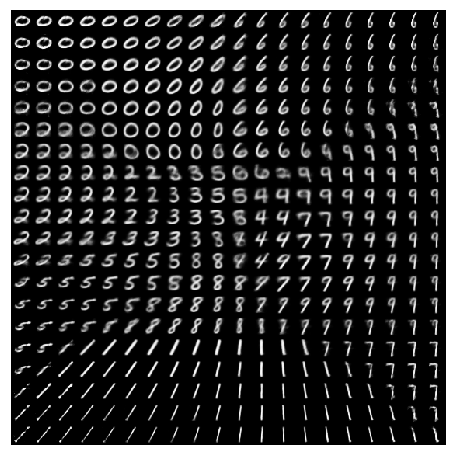

In [28]:
N = 20
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
z = np.linspace(-4, 4, N)


img = np.zeros([N*28, N*28])
for k in range(N * N):
    i, j = k // N, k % N
    
    embedding = torch.tensor([z[i], z[j]])
    x = vae.decoder(embedding).detach().cpu().numpy()
    x = x.reshape(28, 28)
    
    img[28 * i : 28 * (i + 1), 28 * j : 28 * (j + 1)] = x
            
display_number(img, ax)
ax.set_aspect('equal')

fig.savefig('fig/samples.png')
plt.show()


## Showing embedding of each test sample


In [7]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def get_embeddings(model, dataset):
    
    embeddings = []
    for x, label in dataset:
        c = one_hot_to_int(label, 10)
        mu, logvar = vae.encoder(x)
        mu = mu.detach().cpu().numpy()
        data = np.concatenate([mu, np.array([c])])
        embeddings.append(data)
    
    return np.array(embeddings)

embeddings = get_embeddings(vae, mnist_train)
    

/home/charles/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


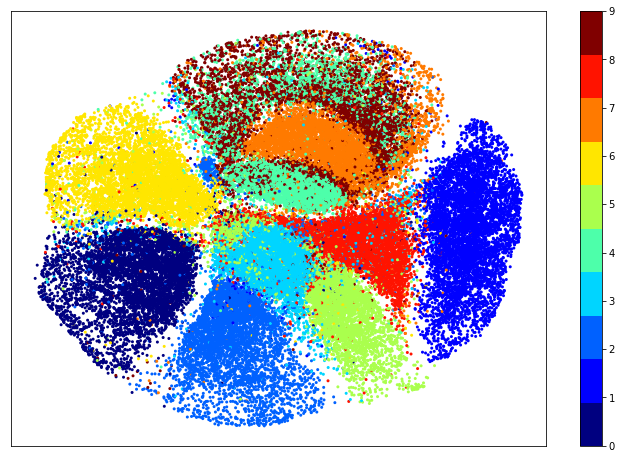

In [27]:
color = discrete_cmap(10, 'jet')
fig, ax = plt.subplots(1, 1, figsize=(12,8))

c_ = [color(int(i)) for i in embeddings[:, 2]]

sc = ax.scatter(embeddings[:,0], embeddings[:,1], c=embeddings[:, 2], marker='.',
                 edgecolor='none', cmap=discrete_cmap(10, 'jet'))

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
#ax.set_aspect('equal')
plt.colorbar(sc, ticks=list(range(N)))
fig.savefig('fig/embeddin_space.png')

plt.show()
#print(color(2.))